In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU Memory growth set successfully.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)

GPU Memory growth set successfully.


In [3]:
import os
import json
import pandas as pd

In [4]:
base_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence'
data_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\data'
models_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\image captioning 1\models'
pre_processed_data_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\image captioning 1\pre_processed_data'

In [5]:
train_captions = os.path.join(pre_processed_data_dir, 'train_captions.txt')
test_captions = os.path.join(pre_processed_data_dir, 'test_captions.txt')
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')

In [6]:
TOTAL_IMAGES_TRAIN = len(os.listdir(train_img_dir))
TOTAL_IMAGES_TEST = len(os.listdir(test_img_dir))
TOTAL_CAPTIONS_TRAIN = TOTAL_IMAGES_TRAIN * 5
TOTAL_CAPTIONS_TEST = TOTAL_IMAGES_TEST * 5

In [7]:
!pip install contractions

In [8]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import string


class ImageFeatureExtractor:
    def __init__(self):
        self.model = self.create_inception_model()

    # Create the InceptionV3 model without the top layer
    def create_inception_model(self):
        base_model = InceptionV3(weights='imagenet', include_top=False)
        model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
        return model

    # Preprocess image for InceptionV3 model
    def preprocess_image(self, image_path):
        img = Image.open(image_path).convert("RGB")  # Convert image to RGB to ensure 3 channels
        img = img.resize((299, 299))  # Resize to 299x299 (expected by InceptionV3)
        # img = np.array(img)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # Preprocess for InceptionV3
        return img

    # Extract features for a given image
    def extract_features(self, image_path):
        try:
            img = self.preprocess_image(image_path)
            features = self.model.predict(img)
            return features.flatten()  # Flatten the features immediately
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None

    # Extract features for the first `limit` images in the directory
    def extract_features_for_directory(self, image_dir, limit=100):
        image_features = {}
        img_files = os.listdir(image_dir)[:limit]

        for img_name in img_files:
            img_path = os.path.join(image_dir, img_name)

            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping unsupported file: {img_name}")
                continue

            img_id = os.path.splitext(img_name)[0]  # Remove file extension for unique ID

            features = self.extract_features(img_path)
            if features is not None:
                image_features[img_id] = features  # Store flattened features
        return image_features

In [10]:
import string
import re
import contractions
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
import nltk

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\UTKARSH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\UTKARSH\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTKARSH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
class CaptionProcessor:
    def __init__(self, captions_file, image_ids):
        self.captions_file = captions_file
        self.image_ids = image_ids  # Limit to selected image IDs

        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        self.captions_dict = self.load_and_preprocess_captions()
        self.tokenizer = self.create_tokenizer()
        self.max_len = self.calculate_max_len()


    def load_and_preprocess_captions(self):
        with open(self.captions_file, 'r') as file:
            raw_captions = file.read()

        captions_dict = {}
        table = str.maketrans('', '', string.punctuation)

        for line in raw_captions.split('\n'):
            tokens = line.split(',')

            # Continue if the line is too short to contain a valid caption
            if len(tokens) < 2:
                continue

            image_id = tokens[0].split('.')[0]  # Extract image ID
            caption = ' '.join(tokens[1:]).strip()

            # Convert to lowercase
            caption = caption.lower()

            # Expand contractions (e.g., "can't" → "cannot")
            caption = contractions.fix(caption)

            # Remove punctuation
            caption = caption.translate(table)

            # Remove numbers
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())

            # Normalize whitespace
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Remove stopwords (optional)
            caption = ' '.join([word for word in caption.split() if word not in self.stop_words])

            # Apply lemmatization
            caption = ' '.join([self.lemmatizer.lemmatize(word) for word in caption.split()])

            # Remove Single character word.
            caption = ' '.join([word for word in caption.split() if len(word) > 1])

            if not caption:  # Skip empty captions
                continue

            # Capitalize the first letter of the caption
            caption = caption[0].upper() + caption[1:]

            if image_id in self.image_ids:  # Only use captions for selected images
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append('startseq ' + caption + ' endseq')
        return captions_dict

    def create_tokenizer(self):
        all_captions = []
        for key in self.captions_dict:
            all_captions.extend(self.captions_dict[key])
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(all_captions)
        return tokenizer

    def calculate_max_len(self):
        return max(len(caption.split()) for captions in self.captions_dict.values() for caption in captions)

    def create_sequences(self, image_features, vocab_size):
        X1, X2, y = [], [], []

        for key, captions_list in self.captions_dict.items():
            if key not in image_features:  # Skip keys not in image_features
                continue

            for caption in captions_list:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(image_features[key])  # Use flattened image features
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

def generate_caption(model, image_feature, tokenizer, max_len):
        in_text = 'startseq'

        for _ in range(max_len):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_len)

            # Predict next word
            yhat = model.predict([image_feature, sequence], verbose=0)
            yhat = np.argmax(yhat)

            # Convert index to word
            word = tokenizer.index_word.get(yhat, None)

            # if word is None:
            #     break

            if not word:  # If word is None, skip to next iteration
              continue

            in_text += ' ' + word
            if word == 'endseq':
                break

        return in_text
        # # return in_text.replace('startseq ', '').replace(' endseq', '')

In [12]:
from tensorflow.keras.utils import Sequence
class ImageCaptionDataGenerator(Sequence):
    def __init__(self, image_features, captions_dict, tokenizer, max_len, vocab_size, batch_size=32):
        self.image_features = image_features
        self.captions_dict = captions_dict
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.image_ids = list(image_features.keys())

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_image_ids = self.image_ids[index * self.batch_size: (index + 1) * self.batch_size]
        X1, X2, y = [], [], []
        for image_id in batch_image_ids:
            image_feature = self.image_features[image_id]
            for caption in self.captions_dict.get(image_id, []):
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_len)[0]
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        return [np.array(X1, dtype=np.float32), np.array(X2, dtype=np.float32)], np.array(y, dtype=np.float32)

In [13]:
import os
import json
import pickle
import string
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input, Masking, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

In [14]:
# Step 1: Extract image features
extractor = ImageFeatureExtractor()

# train_image_features = extractor.extract_features_for_directory(train_img_dir, limit=1000)
# pickle.dump(train_image_features, open(os.path.join(pre_processed_data_dir, 'train_image_features.pkl'), 'wb'))


# test_image_features = extractor.extract_features_for_directory(test_img_dir, limit=100)
# pickle.dump(test_image_features, open(os.path.join(pre_processed_data_dir, 'test_image_features.pkl'), 'wb'))


In [15]:
train_image_features = pickle.load(open(os.path.join(pre_processed_data_dir, 'train_image_features.pkl'), 'rb'))
test_image_features = pickle.load(open(os.path.join(pre_processed_data_dir, 'test_image_features.pkl'), 'rb'))

In [16]:
# #Custom Model
# def build_model(vocab_size, max_len):
#     image_input = Input(shape=(2048,))  # 2048 features from InceptionV3
#     image_dense = Dense(256, activation='relu')(image_input)
#     # Image feature input

#     # Sequence input
#     seq_input = Input(shape=(max_len,))
#     seq_masking = Masking(mask_value=0)(seq_input)
#     seq_embedding = Embedding(vocab_size, 256, mask_zero=False)(seq_masking)

#     # Stacking three LSTM layers
#     lstm_1 = LSTM(256, return_sequences=True, name="lstm_layer_1")(seq_embedding)
#     lstm_2 = LSTM(256, return_sequences=True, name="lstm_layer_2")(lstm_1)
#     lstm_3 = LSTM(256, name="lstm_layer_3")(lstm_2)

#     # Combine the inputs
#     combined = Add()([image_dense, lstm_3])
#     output = Dense(vocab_size, activation='softmax')(combined)

#     model = Model(inputs=[image_input, seq_input], outputs=output)
#     model.compile(optimizer='adam', loss='categorical_crossentropy')
#     return model

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Masking, Add, Multiply, Softmax, Bidirectional
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Custom Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.attn_dense = Dense(256, activation='tanh')
        self.attn_score = Dense(1, activation='softmax')

    def call(self, lstm_output):
        attention = self.attn_dense(lstm_output)
        attention = self.attn_score(attention)
        context = Multiply()([lstm_output, attention])  # Apply attention scores
        return K.sum(context, axis=1)  # Summing over time steps

# Updated Model
def build_model(vocab_size, max_len):
    # Image feature input
    image_input = Input(shape=(2048,))
    image_dense = Dense(256, activation='relu')(image_input)
    image_dense = Dropout(0.5)(image_dense)

    # Sequence input
    seq_input = Input(shape=(max_len,))
    seq_embedding = Embedding(vocab_size, 256, mask_zero=True)(seq_input)
    seq_dropout = Dropout(0.5)(seq_embedding)

    # LSTM layers
    lstm_1 = Bidirectional(LSTM(256, return_sequences=True, name="lstm_layer_1"))(seq_dropout)
    lstm_2 = Bidirectional(LSTM(256, return_sequences=True, name="lstm_layer_2"))(lstm_1)

    # Attention Layer
    attention_layer = AttentionLayer()
    attention_output = attention_layer(lstm_2)

    # Reduce LSTM Output to Match Image Feature Size
    attention_dense = Dense(256, activation='relu')(attention_output)

    # Combine image and text features
    combined = Add()([image_dense, attention_dense])  # Now both are (256,)
    combined_dense = Dense(256, activation='relu')(combined)

    # Final output layer
    output = Dense(vocab_size, activation='softmax')(combined_dense)

    # Build and compile model
    model = Model(inputs=[image_input, seq_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model


In [18]:
# from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Add, Masking, Dropout, Bidirectional
# from tensorflow.keras.models import Model
# import tensorflow.keras.backend as K

# def attention_layer(hidden_states):
#     # Attention mechanism
#     attention = Dense(256, activation='tanh')(hidden_states)
#     attention = Dense(1, activation='softmax')(attention)
#     attention_output = hidden_states * attention  # Apply attention scores
#     return K.sum(attention_output, axis=1)

# def build_improved_model(vocab_size, max_len):
#     # Image feature input
#     image_input = Input(shape=(2048,))
#     image_dense = Dense(512, activation='relu')(image_input)
#     image_dense = Dropout(0.3)(image_dense)

#     # Sequence input
#     seq_input = Input(shape=(max_len,))
#     seq_embedding = Embedding(vocab_size, 256, mask_zero=True)(seq_input)
    
#     # LSTM layers with attention
#     lstm_1 = Bidirectional(LSTM(256, return_sequences=True, name="lstm_layer_1"))(seq_embedding)
#     lstm_2 = Bidirectional(LSTM(256, return_sequences=True, name="lstm_layer_2"))(lstm_1)
#     lstm_3 = Bidirectional(LSTM(256, return_sequences=True, name="lstm_layer_3"))(lstm_2)
    
#     # Apply Attention
#     attention_output = attention_layer(lstm_3)

#     # Combine image features and text features
#     combined = Add()([image_dense, attention_output])
#     combined = Dense(512, activation='relu')(combined)
#     combined = Dropout(0.3)(combined)

#     # Final output layer
#     output = Dense(vocab_size, activation='softmax')(combined)

#     model = Model(inputs=[image_input, seq_input], outputs=output)
#     model.compile(optimizer='adam', loss='categorical_crossentropy')

#     return model

In [19]:
# Step 2: Process captions for the selected images
train_image_ids = list(train_image_features.keys())
train_processor = CaptionProcessor(train_captions, train_image_ids)

test_image_ids = list(test_image_features.keys())
test_processor = CaptionProcessor(test_captions, test_image_ids)

VOCAB_SIZE = len(train_processor.tokenizer.word_index) + 1
MAX_LEN = train_processor.max_len

In [23]:
train_generator = ImageCaptionDataGenerator(train_image_features, train_processor.captions_dict, train_processor.tokenizer, MAX_LEN, VOCAB_SIZE, batch_size=16)
test_generator = ImageCaptionDataGenerator(test_image_features, test_processor.captions_dict, test_processor.tokenizer, MAX_LEN, VOCAB_SIZE, batch_size=16)

In [24]:
mymodel = build_model(VOCAB_SIZE, MAX_LEN)
mymodel.summary()
# plot_model(mymodel, show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 25, 256)      740352      ['input_5[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 25, 256)      0           ['embedding_1[0][0]']            
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 25, 512)     1050624     ['dropout_3[0][0]']              
 )                                                                                          

In [25]:
history = mymodel.fit(train_generator, epochs=50)

Epoch 1/50
63/63 [==============================] - 33s 328ms/step - loss: 6.2785
Epoch 2/50
63/63 [==============================] - 21s 327ms/step - loss: 5.7581
Epoch 3/50
63/63 [==============================] - 21s 325ms/step - loss: 5.6170
Epoch 4/50
63/63 [==============================] - 21s 325ms/step - loss: 5.5055
Epoch 5/50
63/63 [==============================] - 21s 329ms/step - loss: 5.3807
Epoch 6/50
63/63 [==============================] - 21s 326ms/step - loss: 5.2764
Epoch 7/50
63/63 [==============================] - 20s 325ms/step - loss: 5.1745
Epoch 8/50
63/63 [==============================] - 21s 325ms/step - loss: 5.0666
Epoch 9/50
63/63 [==============================] - 21s 326ms/step - loss: 4.9534
Epoch 10/50
63/63 [==============================] - 21s 327ms/step - loss: 4.8253
Epoch 11/50
63/63 [==============================] - 21s 326ms/step - loss: 4.7099
Epoch 12/50
63/63 [==============================] - 22s 351ms/step - loss: 4.5708
Epoch 13/50
6

In [26]:
def plot_history(history):

    loss = history.history['loss']
    # val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    # plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

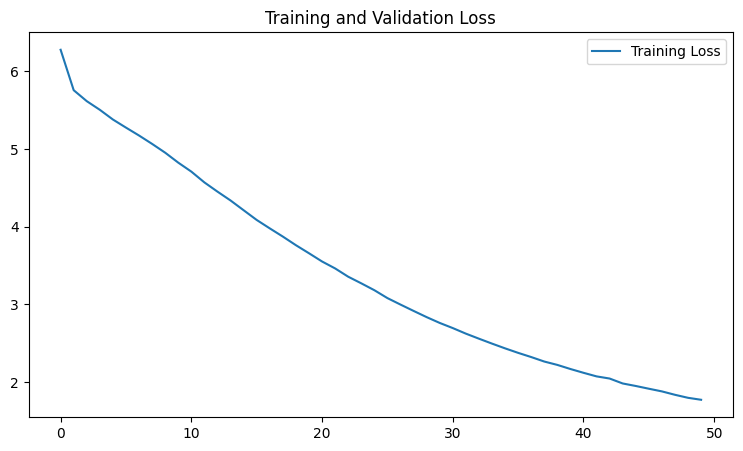

In [27]:
plot_history(history)

In [28]:
mymodel.save(os.path.join(models_dir,'custom_model_attention.h5'))

In [29]:
from tensorflow.keras.models import load_model

# Import your custom AttentionLayer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  # Accept extra arguments
        super(AttentionLayer, self).__init__(**kwargs)  
        self.attn_dense = Dense(256, activation='tanh')
        self.attn_score = Dense(1, activation='softmax')

    def call(self, lstm_output):
        attention = self.attn_dense(lstm_output)
        attention = self.attn_score(attention)
        context = Multiply()([lstm_output, attention])  
        return K.sum(context, axis=1)



In [30]:
# load_model = load_model(os.path.join(models_dir,'custom_model_attention.h5'))
from tensorflow.keras.models import load_model

# Load the model with custom layer
load_model = load_model(os.path.join(models_dir, 'custom_model_attention.h5'), 
                   custom_objects={"AttentionLayer": AttentionLayer})


1/1 [==============================] - 4s 4s/step
Actual Caption: ----------------------------
startseq Large kite flying high sky endseq
startseq Large orange white kite flying blue sky endseq
startseq Colorful parachute sky endseq
startseq Large white red parasail blue sky endseq
startseq Red white parachute sky endseq
--------------------------------------------
Generated Caption:  startseq man next piece sitting sitting dinner luggage adult endseq


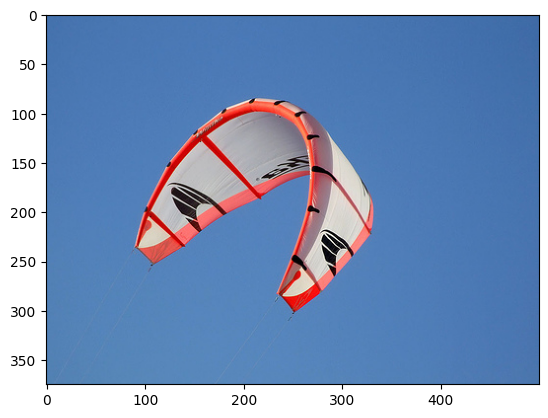

In [31]:
# Step 5: Test caption generation on a new image

model = load_model
random_id = np.random.choice(list(test_processor.captions_dict.keys()))
cap_id = random_id
test_image_path = os.path.join(test_img_dir, cap_id +'.jpg')
test_image_feature = extractor.extract_features(test_image_path)
test_image_feature = np.squeeze(test_image_feature)
generated_caption = generate_caption(model, np.array([test_image_feature]), test_processor.tokenizer, MAX_LEN)

print("Actual Caption: ----------------------------")
for cap in test_processor.captions_dict[cap_id]:
  print(cap)
print("--------------------------------------------")

print("Generated Caption: ", generated_caption)

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 32ms/step
Actual Caption: ----------------------------
startseq Three duck next shore pond endseq
startseq Flock duck floating top lake endseq
startseq Three duck water outside endseq
startseq Three goose standing pond endseq
startseq Three duck walking along dock near water endseq
--------------------------------------------
Generated Caption:  startseq two woman sitting table looking towards head glass wine front one endseq


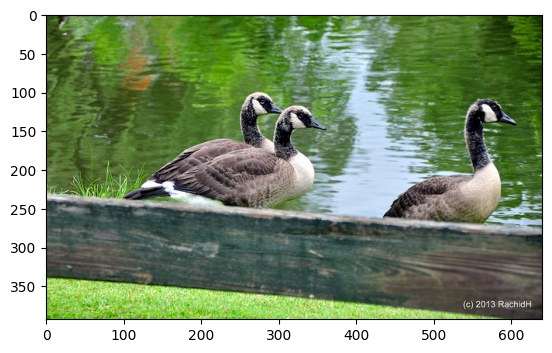

In [32]:
# Step 5: Train caption generation on a new image

model = load_model
random_id = np.random.choice(list(train_processor.captions_dict.keys()))
cap_id = random_id
train_image_path = os.path.join(train_img_dir, cap_id +'.jpg')
train_image_feature = extractor.extract_features(train_image_path)
train_image_feature = np.squeeze(train_image_feature)
generated_caption = generate_caption(model, np.array([train_image_feature]), train_processor.tokenizer, MAX_LEN)

print("Actual Caption: ----------------------------")
for cap in train_processor.captions_dict[cap_id]:
  print(cap)
print("--------------------------------------------")

print("Generated Caption: ", generated_caption)

# Display the image
img = Image.open(train_image_path)
plt.imshow(img)
plt.show()

In [33]:
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# def calculate_bleu(test_features, test_captions, model, tokenizer, MAX_LEN):

#     bleu_1_scores = []
#     bleu_2_scores = []
#     bleu_3_scores = []
#     bleu_4_scores = []

#     for image_id, image_features in test_features.items():
#         predicted_caption = generate_caption(model, np.array([image_features]), tokenizer, MAX_LEN)
#         predicted_caption = predicted_caption.split()

#         # Get the list of ground truth captions for this image
#         reference_captions = [caption.split() for caption in test_captions[image_id]]

#         # Smoothing function for higher n-grams
#         smooth_fn = SmoothingFunction().method1

#         # BLEU-1 (Unigrams)
#         bleu_1 = sentence_bleu(reference_captions, predicted_caption, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)

#         # BLEU-2 (Unigrams + Bigrams)
#         bleu_2 = sentence_bleu(reference_captions, predicted_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)

#         # BLEU-3 (Unigrams + Bigrams + Trigrams)
#         bleu_3 = sentence_bleu(reference_captions, predicted_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)

#         # BLEU-4 (Unigrams + Bigrams + Trigrams + 4-grams)
#         bleu_4 = sentence_bleu(reference_captions, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

#         #Storing BLEU-1,BLEU-2,BLEU-3,BLEU-4
#         bleu_1_scores.append(bleu_1)
#         bleu_2_scores.append(bleu_2)
#         bleu_3_scores.append(bleu_3)
#         bleu_4_scores.append(bleu_4)

#     #Return the average BLEU score across all test images
#     return [np.mean(bleu_1_scores),np.mean(bleu_2_scores),np.mean(bleu_3_scores),np.mean(bleu_4_scores)]

In [34]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(test_features, test_captions, model, tokenizer, MAX_LEN):
    bleu_1_scores, bleu_2_scores, bleu_3_scores, bleu_4_scores = [], [], [], []

    for image_id, image_features in tqdm(test_features.items(), desc="Calculating BLEU Scores", unit="image"):
        predicted_caption = generate_caption(model, np.array([image_features]), tokenizer, MAX_LEN)
        predicted_caption = predicted_caption.split()

        # Get the list of ground truth captions for this image
        reference_captions = [caption.split() for caption in test_captions.get(image_id, [])]

        # Smoothing function for higher n-grams
        smooth_fn = SmoothingFunction().method1

        # Compute BLEU scores
        bleu_1 = sentence_bleu(reference_captions, predicted_caption, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
        bleu_2 = sentence_bleu(reference_captions, predicted_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
        bleu_3 = sentence_bleu(reference_captions, predicted_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
        bleu_4 = sentence_bleu(reference_captions, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

        # Store BLEU scores
        bleu_1_scores.append(bleu_1)
        bleu_2_scores.append(bleu_2)
        bleu_3_scores.append(bleu_3)
        bleu_4_scores.append(bleu_4)

    # Return average BLEU scores
    return [np.mean(bleu_1_scores), np.mean(bleu_2_scores), np.mean(bleu_3_scores), np.mean(bleu_4_scores)]


In [35]:
bleu_score = calculate_bleu(test_image_features, test_processor.captions_dict, model, test_processor.tokenizer, MAX_LEN)
print(f"Average BLEU-1 Score on Test Dataset: {bleu_score[0]:.4f}")
print(f"Average BLEU-2 Score on Test Dataset: {bleu_score[1]:.4f}")
print(f"Average BLEU-3 Score on Test Dataset: {bleu_score[2]:.4f}")
print(f"Average BLEU-4 Score on Test Dataset: {bleu_score[3]:.4f}")

Calculating BLEU Scores: 100%|████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/image]

Average BLEU-1 Score on Test Dataset: 0.2770
Average BLEU-2 Score on Test Dataset: 0.0653
Average BLEU-3 Score on Test Dataset: 0.0452
Average BLEU-4 Score on Test Dataset: 0.0388


In [ ]:
bleu_score = calculate_bleu(train_image_features, train_processor.captions_dict, model, train_processor.tokenizer, MAX_LEN)
print(f"Average BLEU-1 Score on Test Dataset: {bleu_score[0]:.4f}")
print(f"Average BLEU-2 Score on Test Dataset: {bleu_score[1]:.4f}")
print(f"Average BLEU-3 Score on Test Dataset: {bleu_score[2]:.4f}")
print(f"Average BLEU-4 Score on Test Dataset: {bleu_score[3]:.4f}")